# CNN-BiLSTM phishing detection
This notebook prepares the Kaggle-style concatenated phishing email dataset, builds a CNN + Bidirectional LSTM model, trains it, and evaluates against classical metrics (Accuracy, Precision, Recall, F1).

Notes: Minimal preprocessing as requested (no stemming/lemmatization/stopword removal). The architecture uses a small compatibility adjustment so the model runs: Conv1D -> Bidirectional(LSTM(return_sequences=True)) -> GlobalMaxPooling1D -> Dense. This preserves the spirit of convolutional feature extraction followed by sequence modeling and pooling.

In [1]:
# Standard imports
import os
import re
import time
import pickle
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility (best-effort)
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Load dataset (adjust path if necessary)
csv_path = os.path.join('csv', 'Phishing_Email.csv')
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
print('columns:', df.columns.tolist())
TEXT_COL = 'Email Text'
LABEL_COL = 'Email Type'
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
# Map labels to binary: phishing=1, safe=0 (case-insensitive match)
df['label'] = df[LABEL_COL].str.lower().str.contains('phish').astype(int)
df.head()

columns: ['Unnamed: 0', 'Email Text', 'Email Type']


,Email Text,Email Type,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


In [5]:
def clean_text(text):
    if text is None:
        return ""
    # Remove HTML tags
    try:
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text(separator=' ')
    except Exception:
        # fallback to regex if bs4 fails
        text = re.sub(r'<[^>]+>', ' ', str(text))
    # Lowercase
    text = text.lower()
    # Remove complex punctuation and non-alphanumeric chars except spaces (keep basic punctuation optional)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning (this is intentionally minimal)
df['clean_text'] = df[TEXT_COL].astype(str).apply(clean_text)
df[['clean_text','label']].head()

C:\Users\rafro\AppData\Local\Temp\ipykernel_3996\3001456994.py:6: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, 'html.parser')


,clean_text,label
0,re 6 1100 disc uniformitarianism re 1086 sex l...,0
1,the other side of galicismos galicismo is a sp...,0
2,re equistar deal tickets are you still availab...,0
3,hello i am your hot lil horny toy i am the one...,1
4,software at incredibly low prices 86 lower dra...,1


In [6]:
# Train-test split (stratified)
train_texts, test_texts, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=SEED, stratify=df['label'])
print('train size:', len(train_texts), 'test size:', len(test_texts))

train size: 14907 test size: 3727


In [ ]:
# Tokenizer and sequences
VOCAB_SIZE = 20000  # you can increase/decrease based on data and memory
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)
# sequence conversion
train_seqs = tokenizer.texts_to_sequences(train_texts)
test_seqs = tokenizer.texts_to_sequences(test_texts)
# Analyze lengths to choose MAX_SEQUENCE_LENGTH (95th percentile)
lengths = [len(s) for s in train_seqs]
MAX_SEQUENCE_LENGTH = int(np.percentile(lengths, 95))
print('95th percentile length ->', MAX_SEQUENCE_LENGTH)
# Padding
X_train = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print('X_train shape', X_train.shape, 'X_test shape', X_test.shape)

95th percentile length -> 979
X_train shape (14907, 979) X_test shape (3727, 979)
X_train shape (14907, 979) X_test shape (3727, 979)


In [8]:
# Build model: Embedding -> Conv1D -> Bidirectional LSTM (return_sequences=True) -> GlobalMaxPooling1D -> Dense
def build_model(vocab_size, embedding_dim, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_seq_len))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    # Keep return_sequences=True to keep a sequence for the BiLSTM or subsequent pooling
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

model = build_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model.summary()

c:\Users\rafro\OneDrive\Documents\GitHub\security_use_cases_project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training settings
BATCH_SIZE = 64
EPOCHS = 10
val_split = 0.15
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, 'best_cnn_bilstm.h5')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]
start = time.time()
history = model.fit(X_train, y_train, validation_split=val_split, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
end = time.time()
print(f'Training time: {(end-start):.1f}s')
# Save tokenizer
with open(os.path.join(model_dir, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
# Save final model (best is already saved by checkpoint)
model.save(os.path.join(model_dir, 'final_cnn_bilstm.h5'))

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7574 - loss: 0.4273 - precision: 0.7668 - recall: 0.4850 
Epoch 1: val_loss improved from None to 0.09151, saving model to models\best_cnn_bilstm.h5

Epoch 1: val_loss improved from None to 0.09151, saving model to models\best_cnn_bilstm.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 2667s 13s/step - accuracy: 0.8774 - loss: 0.2420 - precision: 0.9139 - recall: 0.7593 - val_accuracy: 0.9629 - val_loss: 0.0915 - val_precision: 0.9305 - val_recall: 0.9783
Epoch 2/10
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9696 - loss: 0.0781 - precision: 0.9515 - recall: 0.9723 
Epoch 2: val_loss improved from 0.09151 to 0.07507, saving model to models\best_cnn_bilstm.h5

Epoch 2: val_loss improved from 0.09151 to 0.07507, saving model to models\best_cnn_bilstm.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 2632s 13s/step - accuracy: 0.9736 - loss: 0.0642 - precision: 0.9549 - recall: 0.9791 - val_accuracy: 0.9687 - val_loss: 0.0751 - val_precision: 0.9361 - val_recall: 0.9874
Epoch 3/10
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9823 - loss: 0.0406 - precision: 0.9629 - recall: 0.9935 
Epoch 3: val_loss did not improve from 0.07507
198/198 ━━━━━━━━━━━━━━━━━━━━ 2718s 14s/step - accuracy: 0.9819 - loss: 0.0416 - precision: 0.9633 - recall: 0.9918 - val_accuracy: 0.9540 - val_loss: 0.1033 - val_precision: 0.9005 - val_recall: 0.9920
Epoch 4/10

Epoch 3: val_loss did not improve from 0.07507
198/198 ━━━━━━━━━━━━━━━━━━━━ 2718s 14s/step - accuracy: 0.9819 - loss: 0.0416 - precision: 0.9633 - recall: 0.9918 - val_accuracy: 0.9540 - val_loss: 0.1033 - val_precision: 0.9005 - val_recall: 0.9920
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9819 - loss: 0.0396 - precision: 0.9762 - recall: 0.9779 
Epoch 4: val_loss did not imp

In [10]:
# Evaluation on test set
y_prob = model.predict(X_test, batch_size= BATCH_SIZE).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob) if len(np.unique(y_test))>1 else float('nan')
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 501ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 501ms/step
Accuracy: 0.9780, Precision: 0.9539, Recall: 0.9918, F1: 0.9725, ROC AUC: 0.9969
Accuracy: 0.9780, Precision: 0.9539, Recall: 0.9918, F1: 0.9725, ROC AUC: 0.9969


In [19]:
print("===== BiLSTM model =====\n" \
f"Accuracy       {acc:.6f}\n" \
f"Precision      {prec:.6f}\n" \
f"Recall         {rec:.6f}\n" \
f"F1-score       {f1:.6f}\n" \
f"ROC-AUC        {roc_auc:.6f}")

===== BiLSTM model =====
Accuracy       0.977998
Precision      0.953947
Recall         0.991792
F1-score       0.972502
ROC-AUC        0.996941


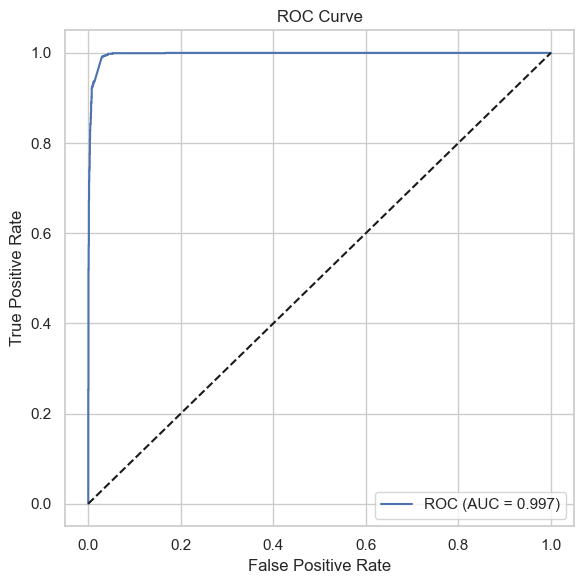

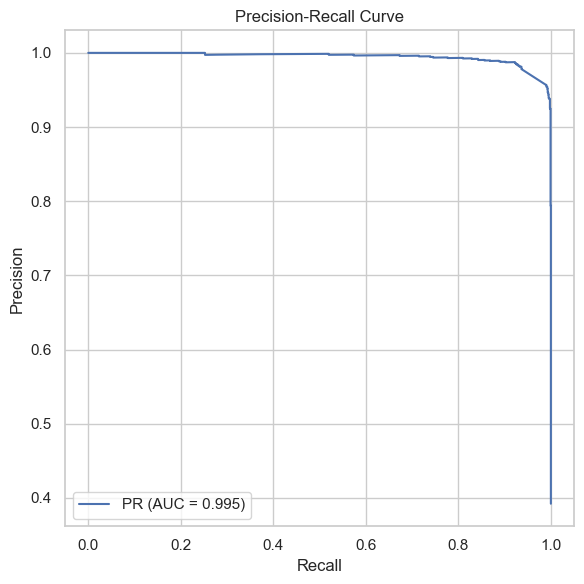

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

# Precision-Recall curve
prec_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_vals, prec_vals)
plt.figure(figsize=(6,6))
plt.plot(recall_vals, prec_vals, label=f'PR (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300)
plt.show()

## Notes and assumptions
- I kept preprocessing minimal as requested (HTML removal, lowercasing, strip non-alphanumerics). No stemming, lemmatization or stopword removal.
- Small compatibility change to the requested layer order: the notebook uses Conv1D -> Bidirectional(LSTM(return_sequences=True)) -> GlobalMaxPooling1D -> Dense so the LSTM receives a sequence (required for LSTM). This maintains the intent: convolution for local features then sequence modeling.
- Default hyperparameters (VOCAB_SIZE=20000, EMBEDDING_DIM=100, epochs=10). Please tune as needed.

## How to run
1. Create a Python environment with required packages (tensorflow, pandas, scikit-learn, bs4, matplotlib, seaborn).
2. In the repository root (where this notebook is), start Jupyter and run this notebook.

## Quick resource guidance
- On CPU, training time depends on dataset size; expect minutes-to-hours. With a GPU, training will be substantially faster.
- Save model artifacts are written to `models/` (`best_cnn_bilstm.h5`, `final_cnn_bilstm.h5`, `tokenizer.pkl`).